In [122]:
import os
import sys
import shutil
import tarfile
import csv


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn import preprocessing
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
from keras.initializers import he_normal, normal
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
from IPython.display import HTML
import pandas as pd

%matplotlib inline
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [98]:
# %load C:\Users\thoma\Documents\Assignments\spam\info.py
#Step 1. read the dataset
x = []
y = []

file_data = r'/content/spambase.data'
file_columns = r"/content/spambase.names"

with open(file_data, 'rt') as csvfile:
    data = csv.reader(csvfile, delimiter=',')
    for raw in data:
        x.append(np.array(raw[:-1], dtype=np.float32))
        y.append(int(raw[-1]))
    
x = np.array(x)
y = np.array(y)

n_ch = x.shape[-1]

#normalize inputs
for ch in range(n_ch):
    ch_v = x[:, ch]
    norm = ch_v.max()
    x[:, ch] /= norm

print(x.shape, y.shape)

# x - 57 parameters descibing exch mail
# y == 1: spam, 0 - not spam.

#Importing columns names
colums=[]
with open(file_columns,"r") as doc:
    lines=doc.readlines()
    for line in lines :
        colums.append(line.split(":")[0])
print(colums)

(4601, 57) (4601,)
['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_table', 'word_freq_conference', 'char_freq_;', 'char_freq_(', 'char_freq_[', 'char_freq_!', 'char_freq_$', 'ch

In [99]:
# Step 2: Some descriptive statistic.
#Only use df_combined for descriptive statistic
df_combined=pd.read_csv(file_data,names=colums)
df_describe = df_combined.describe().round(3)
df_combined.isna().any().any()

False

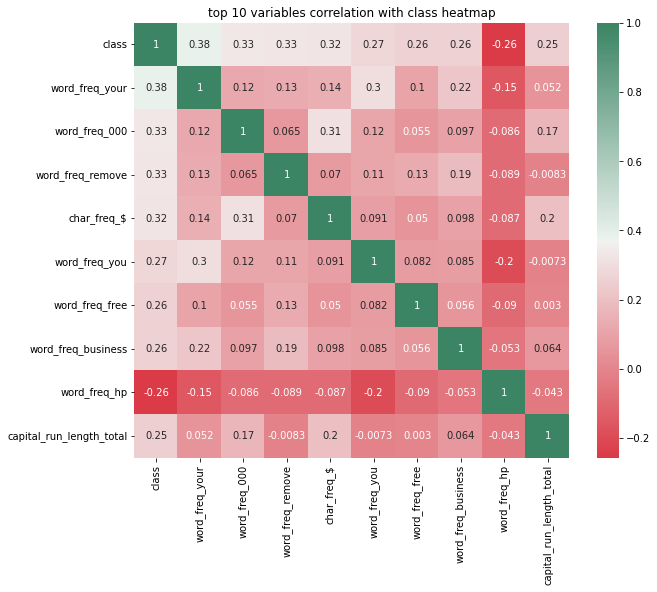

In [100]:
#top correlation with class (negativ and positiv)
k=10 #number of variables
corr=df_combined.corr()
cols=corr.abs().nlargest(k,'class')['class'].index
cm=np.corrcoef(df_combined[cols].values.T)
plt.figure(figsize=(10, 8))
ax=sns.heatmap(cm,yticklabels=cols.values,
                xticklabels=cols.values,
                cmap=sns.diverging_palette(10, 150, as_cmap=True),
                annot=True,
                square=True)
ax.set(title=f"top {k} variables correlation with class heatmap");
plt.show()

[Text(0, 0.5, 'average frequency'),
 Text(0.5, 1.0, 'Non Spam minus Spam average word and char frequency')]

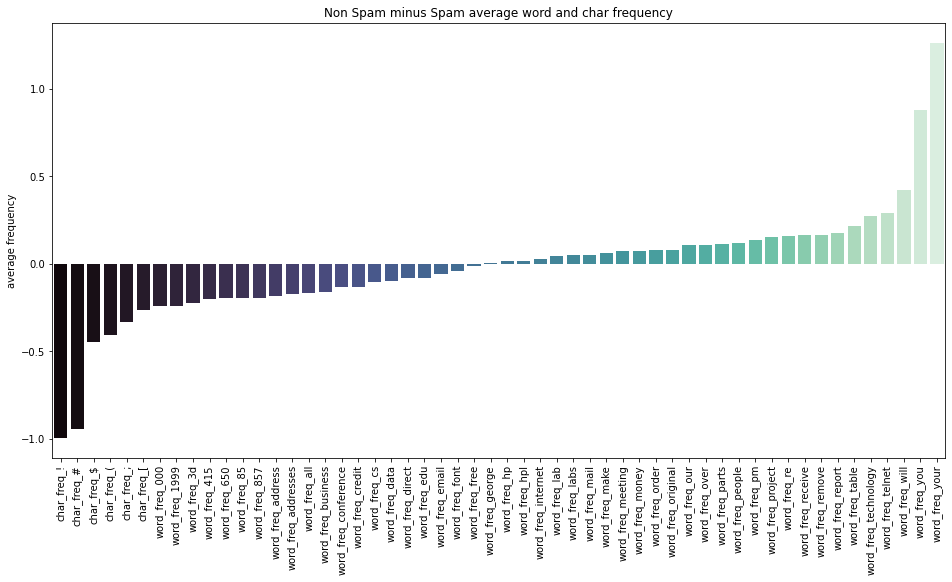

In [101]:
#chart showing the words that are the most frequent in a spam vs. the one less frenquent.
#E.g. in spams we have a lot of chars and numbers
pivot_class_freq=pd.pivot_table(df_combined,values=df_combined.drop(["class","capital_run_length_average","capital_run_length_longest","capital_run_length_total"],axis=1),index='class',aggfunc="mean")
total=pivot_class_freq.iloc[0]-pivot_class_freq.iloc[1]
total = sorted(total)

sns.color_palette("mako", as_cmap=True)
plt.figure(figsize=(16,8))
plt.xticks(rotation=90)
sns.barplot(x=pivot_class_freq.columns,
            y=total,
            palette="mako").set(title="Non Spam minus Spam average word and char frequency",ylabel="average frequency")

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_139 (Dense)           (None, 32)                1856      
                                                                 
 dense_140 (Dense)           (None, 16)                528       
                                                                 
 dense_141 (Dense)           (None, 1)                 17        
                                                                 
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
101/101 [==============================] - 2s 7ms/step - loss: 0.7274 - accuracy: 0.5596 - val_loss: 0.7488 - val_accuracy: 0.1050
Epoch 2/5
101/101 [==============================] - 0s 3ms/step - loss: 0.6323 - accuracy: 0.7040 - val_loss: 0.5930 - val_accuracy: 0.9327
Epoch 3/5
101/101 [==============

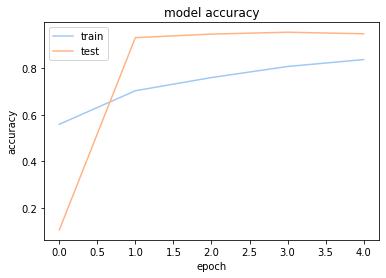

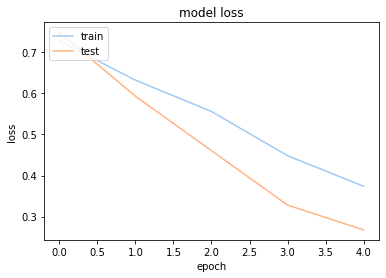

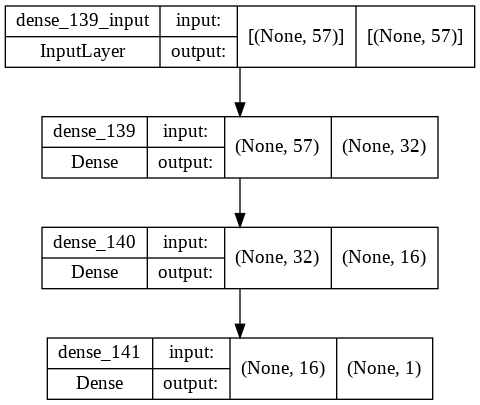

In [134]:
#2. build a fully connected classifier network that will classify the mails.
#Sequential network
def classifier(X, M):
    N = X.shape[1]
    model = tf.keras.Sequential() 
    model.add(tf.keras.layers.Dense(M, input_shape=(N,), activation='relu'))
    model.add(tf.keras.layers.Dense(M/2, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # output
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])    
    model.summary()
    return model

def Plot(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

M = 32
model = classifier(x, M)
#es = EarlyStopping(monitor='val_accuracy', mode='max')
history = model.fit(x, y, validation_split=0.3, epochs= 5, verbose=1, shuffle = False ) # fitting
Plot(history)
tf.keras.utils.plot_model(model, show_shapes=True)


Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 57)]              0         
                                                                 
 dense_136 (Dense)           (None, 32)                1856      
                                                                 
 dense_137 (Dense)           (None, 16)                528       
                                                                 
 dense_138 (Dense)           (None, 1)                 17        
                                                                 
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
101/101 [==============================] - 2s 10ms/step - loss: 0.7248 - accuracy: 0.5491 - val_loss: 0.7316 - val_accuracy: 0.0978
Epoch 2/5
101/101 [===========================

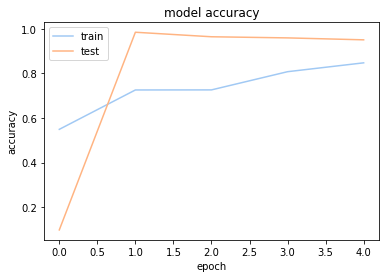

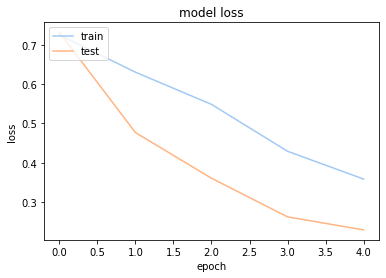

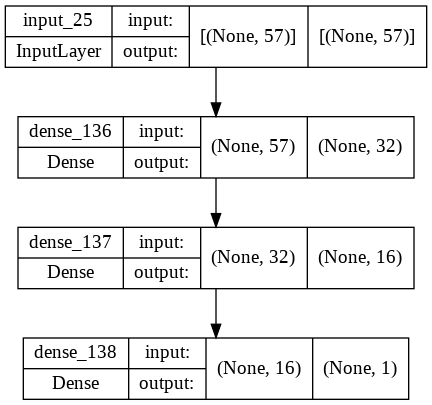

In [133]:
#functional classifier

def classifier_functional(X, M):
    N = X.shape[1]
    layer1 = Input(shape = (N, ))
    layer2 = Dense(M, activation='relu')(layer1)
    layer3 = Dense(M/2, activation='relu')(layer2)
    output = Dense(1, activation='sigmoid')(layer3)
    func_model = Model(inputs =layer1, outputs=output)   
    func_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    func_model.summary()
    return func_model

def Plot(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

M = 32
model = classifier_functional(x, M)
history = model.fit(x, y, validation_split=0.3, epochs= 5, verbose=1, shuffle = False) # fitting
Plot(history)
tf.keras.utils.plot_model(model, show_shapes=True)


In [104]:
#3. check which parameters affect decision the most (biggest gradient wrt to answer)
"DO NOT SHUFFLE DATA- always put shuffle FALSE for this kind of data"
"Now for the parameters = epoch number = 2 and the network is well trained. Select M = 8 to 32 for connected layers so overfitting is avoided."
"make sure that loss of validation is lower than training and look for a minimum - there is the optimal training epoch number"


'make sure that loss of validation is lower than training and look for a minimum - there is the optimal training epoch number'

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_142 (Dense)           (None, 1)                 58        
                                                                 
 dropout_5 (Dropout)         (None, 1)                 0         
                                                                 
 dense_143 (Dense)           (None, 1)                 2         
                                                                 
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
101/101 [==============================] - 1s 4ms/step - loss: 0.6998 - accuracy: 0.5143 - val_loss: 0.7002 - val_accuracy: 0.1731
Epoch 2/20
101/101 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5652 - val_loss: 0.7031 - val_accuracy: 0.1644
Epoch 3/20
101/101 [=================

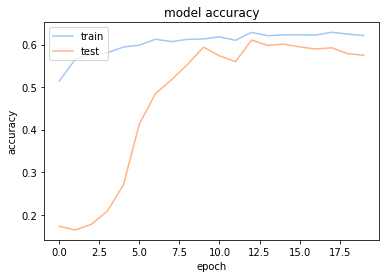

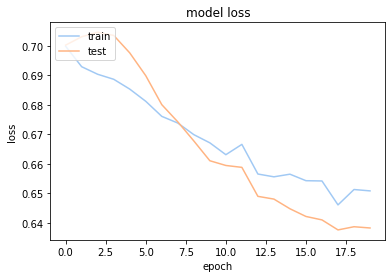

In [135]:
#4. build a classifier that doesn't use 1, 2, 10 most significant parameters. Does it still perform better then random?

def classifier2(X, M, Percentage):
    N = X.shape[1]
    model = tf.keras.Sequential() 
    model.add(tf.keras.layers.Dense(M, input_shape=(N,), activation='relu'))
    model.add(tf.keras.layers.Dropout(Percentage))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # output
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])    
    model.summary()
    return model

M = 1
model = classifier2(x, M, 0.8) # percentage shows the amount of reduced params within network
"Around percentage > 0.7 the network doesn't learn, which is 0.3 * 60 = 18 trainable params "
history = model.fit(x, y, validation_split=0.3, epochs= 20, verbose=1, shuffle = False) # fitting
Plot(history)